In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from PIL import Image
import clip
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COCO_PATH = Path(r"C:\Users\barta\Documents\cours\iaprojets\PDR\code\datasets\coco\train2017\train2017")  
SHIFT_VALUES = list(range(0,3))  
NUM_IMAGES = 10000

print(f"Device utilisé: {DEVICE}")

Device utilisé: cuda


In [12]:
from numba import njit, prange

# --- 1. VOS FONCTIONS NUMBA (Inchangées, gardez-les) ---
@njit
def encrypt_image_bitshift_fast(img_array, shift):
    flat = img_array.ravel()
    out = np.empty_like(flat)
    s = shift % 8
    inv_s = 8 - s
    for i in range(flat.size):
        val = flat[i]
        out[i] = (val << s) | (val >> inv_s)
    return out.reshape(img_array.shape)

@njit
def compute_mi_hist_fast_safe(flat1, flat2, size, bins):
    """
    Version sécurisée contre la division par zéro et les logs infinis.
    """
    # 1. Sécurité : Si taille nulle, on sort direct
    if size == 0:
        return 0.0

    # Initialisation des histogrammes
    joint_hist = np.zeros((bins, bins), dtype=np.int32)
    hist1 = np.zeros(bins, dtype=np.int32)
    hist2 = np.zeros(bins, dtype=np.int32)
    
    # Remplissage
    for i in range(size):
        u = flat1[i]
        v = flat2[i]
        # Sécurité : on s'assure que les indices restent dans les bornes
        if u >= bins: u = bins - 1
        if v >= bins: v = bins - 1
        
        joint_hist[u, v] += 1
        hist1[u] += 1
        hist2[v] += 1
        
    mi = 0.0
    # EPSILON : Un nombre très petit pour éviter la division par 0
    eps = 1e-12
    
    for u in range(bins):
        # Optimisation : Si P(u) est 0, pas la peine de boucler sur v
        if hist1[u] == 0: continue
            
        for v in range(bins):
            # On ne calcule que si on a une co-occurrence
            if joint_hist[u, v] > 0:
                # Cast en float pour la division
                cnt_uv = float(joint_hist[u, v])
                cnt_u = float(hist1[u])
                cnt_v = float(hist2[v])
                
                p_uv = cnt_uv / size
                p_u = cnt_u / size
                p_v = cnt_v / size
                
                # SÉCURITÉ MATHÉMATIQUE
                denominator = p_u * p_v
                if denominator < eps: denominator = eps
                
                ratio = p_uv / denominator
                if ratio < eps: ratio = eps
                
                mi += p_uv * np.log2(ratio)
                
    return mi
def compute_mi_histogram(img1, img2, bins=256):
    """
    Calcule l'information mutuelle entre deux images par histogrammes.
    
    Args:
        img1, img2: np.array de forme (H, W, 3)
        bins: nombre de bins pour l'histogramme
    
    Returns:
        float: information mutuelle moyenne sur les 3 canaux
    """
    mi_values = []
    
    for channel in range(3):
        # Aplatir les canaux
        c1 = img1[:, :, channel].flatten()
        c2 = img2[:, :, channel].flatten()
        
        # Calculer l'IM avec sklearn
        mi = mutual_info_score(c1, c2)
        mi_values.append(mi)
    
    return np.mean(mi_values)

@njit
def compute_entropy_fast(img_array):
    flat = img_array.ravel()
    hist = np.zeros(256, dtype=np.int64)
    for i in range(flat.size): hist[flat[i]] += 1
    entropy = 0.0; size = flat.size
    for i in range(256):
        if hist[i] > 0:
            p = hist[i] / size
            entropy -= p * np.log2(p)
    return entropy


In [13]:
# Charger CLIP
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model.eval()

print("Modèle CLIP chargé avec succès")
print(f"Preprocessing: {preprocess}")

Modèle CLIP chargé avec succès
Preprocessing: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x00000166960FE160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [14]:
def get_clip_embedding(image_array):
    """
    Extrait l'embedding CLIP d'une image.
    
    Args:
        image_array: np.array de forme (H, W, 3) avec valeurs 0-255
    
    Returns:
        np.array: vecteur d'embedding de dimension 512
    """
    # Convertir en PIL Image
    pil_image = Image.fromarray(image_array)
    
    # Prétraitement CLIP
    image_input = preprocess(pil_image).unsqueeze(0).to(DEVICE)
    
    # Extraction de l'embedding
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        # Normalisation
        image_features /= image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().numpy().flatten()


In [15]:
def process_single_image(image_path, shift_values):
    """
    Traite une image pour tous les shifts et calcule les métriques.
    
    Args:
        image_path: Path vers l'image
        shift_values: liste des valeurs de shift à tester
    
    Returns:
        dict contenant toutes les métriques
    """
    # Charger l'image
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Embedding original
    emb_orig = get_clip_embedding(img_array)
    
    # Entropie originale
    entropy_orig = compute_entropy_fast(img_array)
    
    results = []
    
    for shift in shift_values:
        # Chiffrement
        img_encrypted = encrypt_image_bitshift_fast(img_array, shift)
        
        # Embedding chiffré
        emb_enc = get_clip_embedding(img_encrypted)
        
        # IM par histogrammes
        mi_hist = compute_mi_histogram(img_array, img_encrypted)
        
        # Préparer données pour MINE
        df_embeddings = pd.DataFrame({
            'dim_val_orig': emb_orig,
            'dim_val_chiff': emb_enc
        })
        
        results.append({
            'image_path': str(image_path),
            'shift': shift,
            'entropy_original': entropy_orig,
            'mi_histogram': mi_hist,
            'embeddings_df': df_embeddings,
            'embedding_orig': emb_orig,
            'embedding_encrypted': emb_enc
        })
    
    return results

# Test sur une image
test_results = process_single_image(list(COCO_PATH.glob("*.jpg"))[0], [0, 4, 8])
print(f"Nombre de résultats: {len(test_results)}")

Nombre de résultats: 3


In [16]:

def main_analysis_optimized(num_images=NUM_IMAGES, output_path="stats_results.csv", tsne_limit=500,bins=32):
    # Récupérer les images
    image_paths = list(COCO_PATH.glob("*.jpg"))[:num_images]
    
    # 1. Structure pour les statistiques "en ligne"
    # Dictionnaire : shift -> {compteurs}
    stats = {} 
    
    # 2. Listes pour t-SNE (On limite leur taille pour économiser la RAM)
    X_list = []      
    labels_type = [] 
    labels_shift = []
    labels_id = []  
    
    for i, img_path in enumerate(tqdm(image_paths, desc="Analyse Optimisée")):
        try:
            # Traitement de l'image
            img_results = process_single_image(img_path, SHIFT_VALUES)
            
            # --- GESTION INTELLIGENTE DE LA MÉMOIRE T-SNE ---
            # On ne garde les vecteurs que pour les 'tsne_limit' premières images
            keep_for_tsne = (i < tsne_limit)
            
            # Point Original (une seule fois par image)
            res_ref = img_results[0]
            vec_orig = res_ref['embedding_orig'].flatten()
            
            if keep_for_tsne:
                X_list.append(vec_orig)
                labels_type.append("Original")
                labels_shift.append(0)
                labels_id.append(str(i))
            
            # --- BOUCLE SUR LES SHIFTS ---
            for res in img_results:
                vec_enc = res['embedding_encrypted'].flatten()
                shift_val = int(res['shift'])

                # A. Stockage t-SNE (Conditionnel)
                if keep_for_tsne:
                    X_list.append(vec_enc)
                    labels_type.append("Chiffre")
                    labels_shift.append(str(shift_val))
                    labels_id.append(str(i))

                # --- CALCUL C: VOTRE CALCUL DE MI ICI ---
                # (Je remets le squelette rapide pour l'exemple)
                combined = np.concatenate([vec_orig, vec_enc])
                v_min, v_max = combined.min(), combined.max()
                diff = v_max - v_min
                
                mine_result = 0.0
                if diff > 1e-9:
                    vec1_norm = np.clip((vec_orig - v_min) / diff, 0, 0.999)
                    vec2_norm = np.clip((vec_enc - v_min) / diff, 0, 0.999)
                    bins 
                    vec1_b = (vec1_norm * bins).astype(np.int32)
                    vec2_b = (vec2_norm * bins).astype(np.int32)
                    mine_result = compute_mi_hist_fast_safe(vec1_b, vec2_b, vec_orig.size, bins)

                # C. AGRÉGATION STATISTIQUE (Le cœur de l'optimisation)
                if shift_val not in stats:
                    stats[shift_val] = {
                        'count': 0,
                        'mi_sum': 0.0,      'mi_sq_sum': 0.0,
                        'ent_sum': 0.0,     'ent_sq_sum': 0.0
                    }
                
                s = stats[shift_val]
                s['count'] += 1
                
                # Mise à jour MI
                s['mi_sum'] += mine_result
                s['mi_sq_sum'] += mine_result ** 2
                
                # Mise à jour Entropie (ex: entropy_original ou autre métrique)
                ent_val = float(res['entropy_original'])
                s['ent_sum'] += ent_val
                s['ent_sq_sum'] += ent_val ** 2

        except Exception as e:
            # print(f"Err: {e}") # Décommenter pour debug
            continue

    # --- FINALISATION : CALCUL MOYENNE / ÉCART-TYPE ---
    summary_data = []
    
    # On parcourt les stats accumulées pour chaque shift
    for shift, s in stats.items():
        n = s['count']
        if n == 0: continue
        
        # Moyenne E[X]
        mean_mi = s['mi_sum'] / n
        mean_ent = s['ent_sum'] / n
        
        # Variance = E[X^2] - (E[X])^2
        var_mi = (s['mi_sq_sum'] / n) - (mean_mi ** 2)
        var_ent = (s['ent_sq_sum'] / n) - (mean_ent ** 2)
        
        # Écart-type (sqrt(Var))
        std_mi = np.sqrt(max(0, var_mi))   # max(0) évite les erreurs d'arrondi négatives
        std_ent = np.sqrt(max(0, var_ent))
        
        summary_data.append({
            'shift': shift,
            'count': n,
            'mi_mean': mean_mi,
            'mi_std': std_mi,
            'entropy_mean': mean_ent,
            'entropy_std': std_ent
        })
        
    # Création du DataFrame résumé (seulement quelques lignes !)
    df_summary = pd.DataFrame(summary_data).sort_values('shift')
    df_summary.to_csv(output_path, index=False)
    
    # Création de X seulement si on a des données
    X = np.vstack(X_list) if X_list else np.array([])
    
    print(f"Analyse terminée. Résumé sauvegardé.")
    print(f"Matrice t-SNE : {X.shape} (Limitée aux {tsne_limit} premières images)")
    
    return df_summary, X, labels_type, labels_shift, labels_id
BINS = [32]
result =[]
for b in BINS :
    df_final, X, labels_type, labels_shift, labels_id = main_analysis_optimized(num_images=NUM_IMAGES,bins = b)
    result.append(df_final)

Analyse Optimisée: 100%|██████████| 10000/10000 [1:49:24<00:00,  1.52it/s] 

Analyse terminée. Résumé sauvegardé.
Matrice t-SNE : (2000, 512) (Limitée aux 500 premières images)


Dimension de départ : (2000, 512)
Dimension après PCA : (2000, 50)


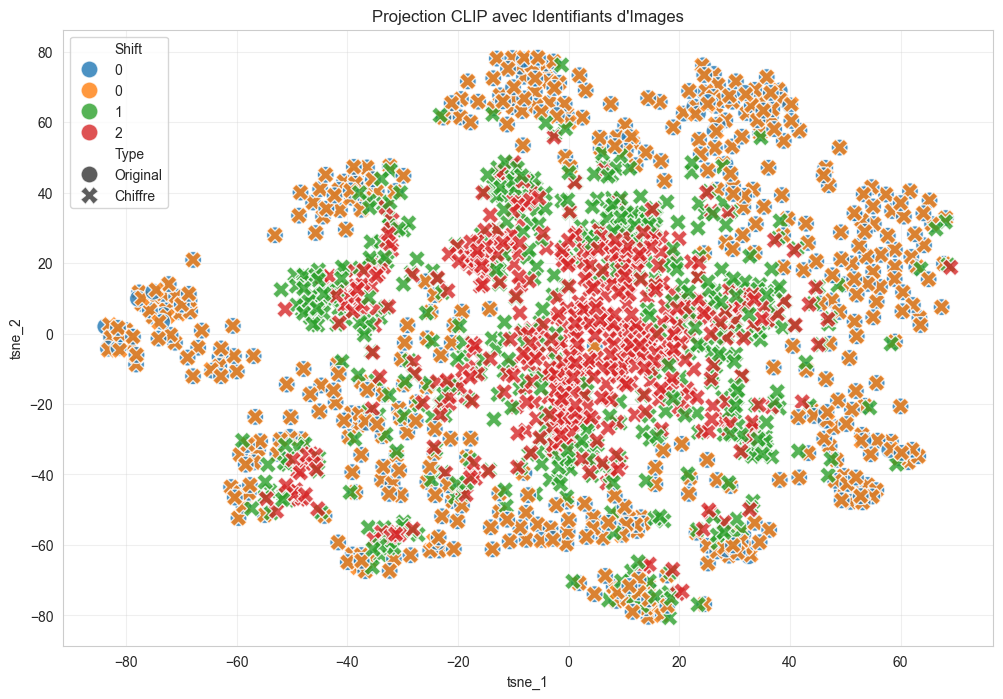

In [17]:

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
# -------------------------------------------------------------------------
# 3. CALCULS (PCA -> TSNE)
# -------------------------------------------------------------------------
print(f"Dimension de départ : {X.shape}")
n_samples = X.shape[0]
n_components_safe = min(50, n_samples, X.shape[1])
# Étape 1 : PCA (Réduction à 50 dimensions pour nettoyer avant t-SNE)
pca = PCA(n_components=n_components_safe)
X_pca = pca.fit_transform(X)
print(f"Dimension après PCA : {X_pca.shape}")

# Étape 2 : t-SNE (Réduction à 2 dimensions)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

# -------------------------------------------------------------------------
# 4. VISUALISATION
# -------------------------------------------------------------------------
# Création d'un DF pour Seaborn
plot_df = pd.DataFrame({
    'tsne_1': X_tsne[:, 0],
    'tsne_2': X_tsne[:, 1],
    'Type': labels_type,      # Original / Chiffre
    'Shift': labels_shift,     # 0, 4, 8...
    'Image_ID': labels_id  # <--- On ajoute la colonne des IDs
})
# 4. Affichage
plt.figure(figsize=(12, 8))
# 1. Le graphique principal
p1 = sns.scatterplot(
    data=plot_df,
    x='tsne_1', y='tsne_2',
    hue='Shift', 
    style='Type',
    markers={"Original": "o", "Chiffre": "X"},
    s=150, alpha=0.8,
    palette="tab10" # Une palette avec des couleurs bien distinctes
)

# 2. La boucle d'annotation (Magie ici)
# On parcourt chaque ligne du dataframe pour écrire le numéro
for line in range(0, plot_df.shape[0]):
    
    # Coordonnées du point
    x = plot_df.tsne_1[line]
    y = plot_df.tsne_2[line]
    txt = plot_df.Image_ID[line]
    
    # Ajout du texte
    # xytext=(5, 5) décale légèrement le texte pour ne pas être SUR le point
    #p1.text(x, y, txt, horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title("Projection CLIP avec Identifiants d'Images")
plt.grid(True, alpha=0.3)
plt.show()

Distance moyenne sur le graphique t-SNE par Shift :
  Shift  visual_distance
0     0         0.053316
1     1        23.674128
2     2        38.544720


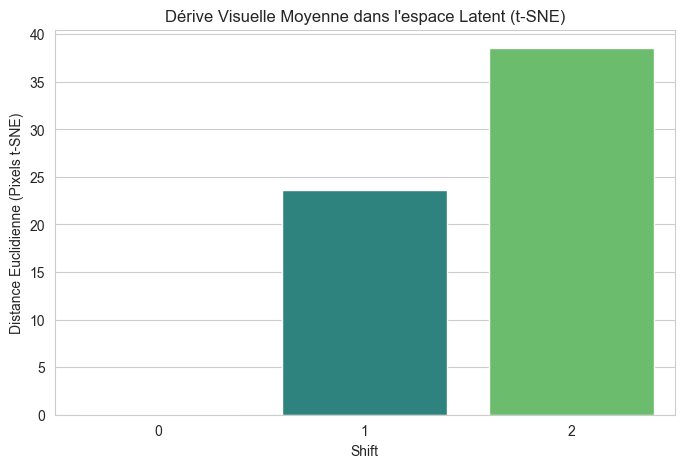

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Séparer les originaux des chiffrés
# On ne garde que ID et coordonnées pour les originaux
df_orig = plot_df[plot_df['Type'] == 'Original'][['Image_ID', 'tsne_1', 'tsne_2']]
df_enc = plot_df[plot_df['Type'] == 'Chiffre']

# 2. Fusionner pour avoir les coordonnées (Orig, Chiffre) sur la même ligne
# On joint sur 'Image_ID'
merged_df = pd.merge(
    df_enc, 
    df_orig, 
    on='Image_ID', 
    suffixes=('_enc', '_orig')
)

# 3. Calcul de la Distance Euclidienne (Visual Drift)
# d = sqrt((x2-x1)^2 + (y2-y1)^2)
merged_df['visual_distance'] = np.sqrt(
    (merged_df['tsne_1_enc'] - merged_df['tsne_1_orig'])**2 + 
    (merged_df['tsne_2_enc'] - merged_df['tsne_2_orig'])**2
)

# 4. Moyenne par Shift
avg_drift = merged_df.groupby('Shift')['visual_distance'].mean().reset_index()

print("Distance moyenne sur le graphique t-SNE par Shift :")
print(avg_drift)

# 5. Visualisation de la métrique
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_drift, x='Shift', y='visual_distance', palette="viridis")
plt.title("Dérive Visuelle Moyenne dans l'espace Latent (t-SNE)")
plt.ylabel("Distance Euclidienne (Pixels t-SNE)")
plt.show()


Similitude Sémantique (Cosine) Moyenne par Shift :
  Shift  Cosine_Similarity
0     0           1.000000
1     1           0.770528
2     2           0.634494


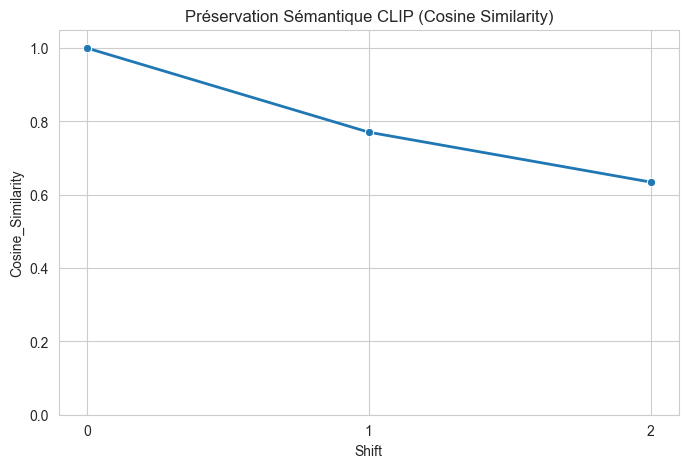

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

df_vecs = pd.DataFrame({
    'Image_ID': labels_id,
    'Type': labels_type,
    'Shift': labels_shift,
    'Index_X': range(len(labels_id)) # Pour retrouver la ligne dans X
})

results_cos = []

# Pour chaque image unique
unique_ids = df_vecs['Image_ID'].unique()

for img_id in unique_ids:
    # Récupérer l'index du vecteur Original
    idx_orig = df_vecs[(df_vecs['Image_ID'] == img_id) & (df_vecs['Type'] == 'Original')]['Index_X'].values
    
    if len(idx_orig) > 0:
        idx_orig = idx_orig[0]
        vec_orig = X[idx_orig].reshape(1, -1) # Format (1, 512)
        
        # Récupérer les vecteurs chiffrés pour cette image
        sub_df = df_vecs[(df_vecs['Image_ID'] == img_id) & (df_vecs['Type'] == 'Chiffre')]
        
        for _, row in sub_df.iterrows():
            idx_enc = row['Index_X']
            shift_val = row['Shift']
            vec_enc = X[idx_enc].reshape(1, -1)
            
            # Calcul Cosine Similarity (de -1 à 1)
            # 1.0 = Identique, 0.0 = Orthogonal, -1.0 = Opposé
            sim = cosine_similarity(vec_orig, vec_enc)[0][0]
            
            results_cos.append({
                'Image_ID': img_id,
                'Shift': shift_val,
                'Cosine_Similarity': sim
            })

# Agrégation
df_sim = pd.DataFrame(results_cos)
avg_sim = df_sim.groupby('Shift')['Cosine_Similarity'].mean().reset_index()

print("\nSimilitude Sémantique (Cosine) Moyenne par Shift :")
print(avg_sim)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_sim, x='Shift', y='Cosine_Similarity', marker='o', linewidth=2)
plt.title("Préservation Sémantique CLIP (Cosine Similarity)")
plt.ylim(0, 1.05) # L'échelle va de 0 à 1
plt.grid(True)
plt.show()

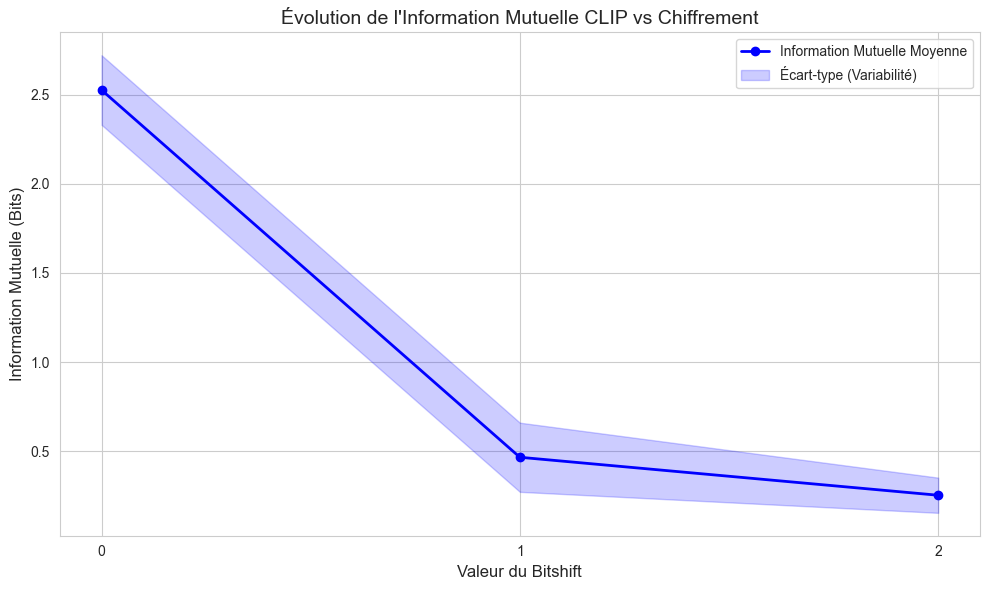

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_mi_evolution(summary_data):
    # 1. Conversion en DataFrame (si ce n'est pas déjà fait)
    if isinstance(summary_data, list):
        df = pd.DataFrame(summary_data)
    else:
        df = summary_data.copy()
        
    # S'assurer que les données sont triées par Shift pour que la ligne ne fasse pas des zig-zags
    df = df.sort_values('shift')

    # 2. Configuration du style
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Tracé de la courbe moyenne
    # On utilise 'marker' pour bien voir les points de mesure
    plt.plot(df['shift'], df['mi_mean'], 
             color='blue', marker='o', linewidth=2, label='Information Mutuelle Moyenne')

    # 4. Tracé de l'écart-type (Zone ombrée)
    # Cela représente la variabilité de la MI d'une image à l'autre
    plt.fill_between(df['shift'], 
                     df['mi_mean'] - df['mi_std'], 
                     df['mi_mean'] + df['mi_std'], 
                     color='blue', alpha=0.2, label='Écart-type (Variabilité)')

    # 5. Esthétique
    plt.title("Évolution de l'Information Mutuelle CLIP vs Chiffrement", fontsize=14)
    plt.xlabel("Valeur du Bitshift", fontsize=12)
    plt.ylabel("Information Mutuelle (Bits)", fontsize=12)
    plt.legend()
    
    # Optionnel : Forcer l'axe X à n'afficher que les entiers si peu de shifts
    if len(df) < 20:
        plt.xticks(df['shift'])

    plt.tight_layout()
    plt.show()

# --- UTILISATION ---
# Appelle la fonction avec ta liste summary_data ou ton DataFrame df_summary
for r in result : 
    plot_mi_evolution(r)